# Transformers From Scratch


## Initialization


In [2]:
from typing import Tuple

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.types import (
    _device,
    _int,
    _size,
    _TensorOrTensors,
)  # used for type hinting. helps intellisense to detect types and also readers to understand each variables easier

from my_transformer import set_seed

set_seed(1999)  # set seed for reproducible results

device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)  # run on gpu for faster optimization if it's available
print(device)

cuda


Loading the sample text to train and validate the implemented gpt model.


In [3]:
with open("assets/input.txt", "r") as f:
    text = f.read()

print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


List of all characters in the dataset


In [4]:
chars = sorted(list(set(text)))
print(repr("".join(chars)))
vocab_size = len(chars)
vocab_size

"\n !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz"


65

Encode and Decode

In [5]:
cton = {c: n for n, c in enumerate(chars)}  # Character to number lookup table
ntoc = {n: c for n, c in enumerate(chars)}  # Number to character lookup table


def encode(s: list[str] | str):
    return [cton[c] for c in s]


def decode(e: list[int] | torch.Tensor | int):
    if isinstance(e, torch.Tensor):
        e = e.tolist()
    if isinstance(e, int):
        return ntoc[e]
    return [ntoc[n] for n in e]


test_text = "This must be properly encoded and decoded!"  # make sure all the characters all available in the loaded text file.
enc_test = encode(test_text)
print(enc_test)
dec_text = decode(enc_test)
print("".join(dec_text))

[32, 46, 47, 57, 1, 51, 59, 57, 58, 1, 40, 43, 1, 54, 56, 53, 54, 43, 56, 50, 63, 1, 43, 52, 41, 53, 42, 43, 42, 1, 39, 52, 42, 1, 42, 43, 41, 53, 42, 43, 42, 2]
This must be properly encoded and decoded!


Get mini-batch of dataset

In [6]:
def get_batch(
    train: torch.Tensor, validation: torch.Tensor, batch_size: int, context_length: int
) -> Tuple[torch.Tensor, torch.Tensor]:
    """get mini-batch from given train and validation datasets

    Args:
        train (torch.Tensor): input dataset
        validation (torch.Tensor): validation dataset
        batch_size (int): batch size
        context_length (int): length window in time dimension

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: mini-batch of train (batch_size, context_length, feature_size), mini-batch of validation (batch_size, context_length)
    """

    assert train.size(0) == validation.size(
        0
    ), "Train and validation should be have same size for dim 0"

    validation = torch.roll(validation, -1)  # To align input and label

    offsets = torch.randint(train.size(0) - context_length, (batch_size,))
    x = torch.stack([train[i : i + context_length] for i in offsets])
    y = torch.stack([validation[i : i + context_length] for i in offsets])

    return x, y

Example of getting mini-batch for test text. run this multiple time to see multiple examples.


In [7]:
inp_tensor = torch.tensor(encode(text))

batch_size = 2
context_length = 12
inp_mini_batch, target_mini_batch = get_batch(
    inp_tensor, inp_tensor, batch_size, context_length
)
print(inp_mini_batch, target_mini_batch)

for b in range(batch_size):
    for i in range(context_length):
        print(
            f"given {repr(''.join(decode(inp_mini_batch[b][:i+1])))}, -> {repr(decode(target_mini_batch[b][i]))}"
        )

tensor([[42, 59, 39, 11,  1, 58, 46, 43, 56, 43,  1, 58],
        [57,  1, 57, 41, 39, 40, 57, 12,  0,  0, 18, 47]]) tensor([[59, 39, 11,  1, 58, 46, 43, 56, 43,  1, 58, 53],
        [ 1, 57, 41, 39, 40, 57, 12,  0,  0, 18, 47, 56]])
given 'd', -> 'u'
given 'du', -> 'a'
given 'dua', -> ';'
given 'dua;', -> ' '
given 'dua; ', -> 't'
given 'dua; t', -> 'h'
given 'dua; th', -> 'e'
given 'dua; the', -> 'r'
given 'dua; ther', -> 'e'
given 'dua; there', -> ' '
given 'dua; there ', -> 't'
given 'dua; there t', -> 'o'
given 's', -> ' '
given 's ', -> 's'
given 's s', -> 'c'
given 's sc', -> 'a'
given 's sca', -> 'b'
given 's scab', -> 's'
given 's scabs', -> '?'
given 's scabs?', -> '\n'
given 's scabs?\n', -> '\n'
given 's scabs?\n\n', -> 'F'
given 's scabs?\n\nF', -> 'i'
given 's scabs?\n\nFi', -> 'r'


### Generate function


In [8]:
@torch.no_grad
def text_generate(
    model: nn.Module,
    initial_token: torch.Tensor,
    max_new_tokens: int,
    context_length: int | None = None,
):
    training = model.training
    model.eval()  # set model to eval mode

    # make it batch-like if it is only a token
    if initial_token.dim() == 1:
        initial_token = initial_token.view(1, -1)  # of size (batch_size, 1)
    tokens = initial_token  # of size (batch_size, context_size)
    for i in range(max_new_tokens):
        logits = model(
            tokens[:, -context_length:] if context_length else tokens
        )  # of size (batch_size, context_size, channel_size)
        # get the last element in context dimension:
        logits = logits[:, -1, :]  # size becomes (batch_size, channel_size)
        # get probability of each token in output
        probs = F.softmax(logits, dim=-1)  # compute softmax on the last dimension
        # sample token
        next_token = torch.multinomial(probs, num_samples=1)  # of size (batch_size, 1)
        # add new token to existing ones
        tokens = torch.cat((tokens, next_token), dim=-1)  # concat on last dimension

    if training:  # if given model was on train mode, return it to that state
        model.train()
    return tokens

Simple test for text generator function


In [9]:
test_model = nn.Embedding(
    vocab_size, vocab_size
)  # instantiate a simple vocab_size * vocab_size lookup table

tokens = text_generate(test_model, torch.zeros((1,), dtype=torch.long), 100)
print("".join(decode(tokens[0])))  # see generated text of the first batch


f
yl!f!!nPXr qsA&u
za OMZmVZm3iLWX3cD.LkTCYad'rlKacTx v;UofvxbMLVq-WtPO;Z&V!eHRSuXxXJoJoBg3xvJkYcjQ:


### Train loop


In [14]:
def train(
    model: nn.Module,
    train_x: torch.Tensor,
    train_y: torch.Tensor,
    iter: int,
    batch_size: int,
    context_length: int,
    lr: float = 1e-3,
    step_verbose: int | None = None,
) -> list:
    """Train given model on given dataset

    Args:
        model (nn.Module): model you want to train
        train_x (torch.Tensor): train input
        train_y (torch.Tensor): train label
        iter (int): number of iterations to train the model
        batch_size (int): batch size
        context_length (int): context length
        lr (float, optional): learning rate. Defaults to 1e-3.
        step_verbose (int | None, optional): whether to show a summary of train in given timestep or not. Defaults to None.

    Returns:
        list: list of loss in each iteration
    """
    loss_list = []
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    for i in range(iter):
        optimizer.zero_grad()
        x, y = get_batch(train_x, train_y, batch_size, context_length)
        out = model(x)
        out = out.view(
            out.size(0) * out.size(1), out.size(2)
        )  # becomes (batch_size*context_length, channel_size)
        # because for cross entropy loss, pytorch accepts (N,C), where C is number of classes
        y = y.view(-1)  # the same for target tensor
        loss = F.cross_entropy(out, y)
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()

        if step_verbose and i % step_verbose == 0:
            print(f"loss at iteration {i} is {loss.item()}")

    return loss_list

## Learn Only by Lookup Embedding


Create model and train it

In [15]:
model = nn.Embedding(vocab_size, vocab_size).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 30, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

loss at iteration 0 is 4.675796031951904
loss at iteration 1000 is 3.4819042682647705
loss at iteration 2000 is 2.9028875827789307
loss at iteration 3000 is 2.637307643890381
loss at iteration 4000 is 2.5339818000793457
loss at iteration 5000 is 2.4952595233917236
loss at iteration 6000 is 2.47721266746521
loss at iteration 7000 is 2.4643585681915283
loss at iteration 8000 is 2.4646036624908447
loss at iteration 9000 is 2.428908586502075
best loss achieved: 2.428908586502075


Loss curve

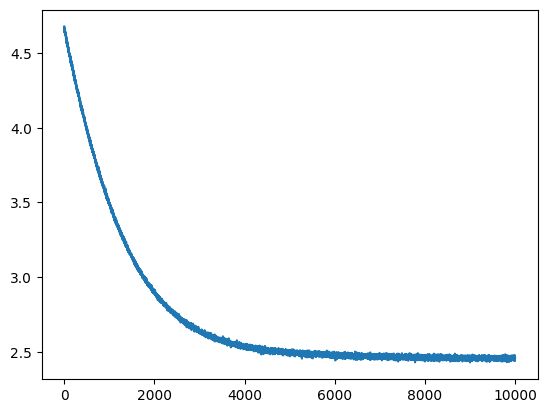

In [16]:
plt.plot(loss_list)
plt.show()

A sample generated by trained model

In [17]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300)
print("".join(decode(tokens[0]))) 


SCEYoun OLANENoberunosth s storff y bolou athacoure-
Theyatr luch, ayote by t aceaseve XFond the Yorn or vinty nsm ctane dittha t fowhat and MAREOK:
Toulirrd te hitid:
ANoufer seid hamfounores ate.
YCHar D pof to ire f strd, berkende byo he pll g ho,
Y:

LI the ge d F ar who se, r: G y y t f ededs o


## Learn by Attention

### Single head attention

#### Define model

In [10]:
from my_transformer import CausalSelfAttentionHead


class SimpleAttentionModel(nn.Module):
    def __init__(
        self, vocab_size: int, context_length: int, embed_size: int, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.char_embed = nn.Embedding(vocab_size, embed_size)
        self.position_embed = nn.Embedding(context_length, embed_size)

        self.atten = CausalSelfAttentionHead(
            embed_size, 32, vocab_size, context_length, 0.01
        )

    def forward(self, x: torch.Tensor):
        char_embed = self.char_embed(x)  # (batch_size, context_length, embed_size)
        position_embed = self.position_embed(
            torch.arange(x.size(-1), device=device)
        )  # (context_length, embed_size)

        embed = char_embed + position_embed
        out = self.atten(embed)  # (batch_size, context_length, vocab_size)

        return out

#### Train

In [11]:
model = SimpleAttentionModel(vocab_size, 64, 32).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 32, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

loss at iteration 0 is 4.13706636428833
loss at iteration 1000 is 2.5706562995910645
loss at iteration 2000 is 2.398519515991211
loss at iteration 3000 is 2.3713207244873047
loss at iteration 4000 is 2.3167507648468018
loss at iteration 5000 is 2.325383424758911
loss at iteration 6000 is 2.3275058269500732
loss at iteration 7000 is 2.309060573577881
loss at iteration 8000 is 2.3067727088928223
loss at iteration 9000 is 2.286986827850342
best loss achieved: 2.255483865737915


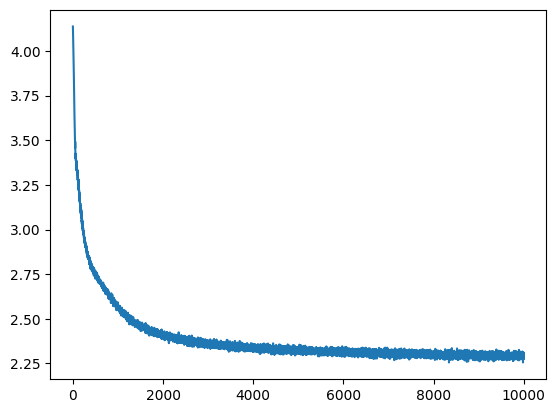

In [12]:
plt.plot(loss_list)
plt.show()

#### Example

In [14]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300, context_length=32)
print("".join(decode(tokens[0]))) 


Dur.

Bed
I'd wothey y'To gath the hee?

TRhis ber bule swe yualist thm, ndy nour thencag heamep ornenas hoy:
A Bud beve.

PEORGIICof hal uold, squeepeen heat p ot wotol cthe er com:
Sonod. And:
That nomero ucepers winf wllel, dis
Thapy neovera mesay lod Nouinst, I shero nanwo!
Corwe-ve coudy, fous.


### Multi-head attention

#### Define Model

In [22]:
from my_transformer import MultiHeadAttention


class MultiHeadAttentionModel(nn.Module):
    def __init__(
        self,
        vocab_size: int,
        context_length: int,
        embed_size: int,
        num_head: int,
        *args,
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)

        self.char_embed = nn.Embedding(vocab_size, embed_size)
        self.position_embed = nn.Embedding(context_length, embed_size)

        self.mh_atten = MultiHeadAttention(
            input_size=embed_size,
            output_size=vocab_size,
            query_key_emb_size=32,
            value_emb_size=32,
            num_head=num_head,
            context_size=context_length,
            dropout_p=0.01,
        )

    def forward(self, x: torch.Tensor):
        char_embed = self.char_embed(x)  # (batch_size, context_length, embed_size)
        position_embed = self.position_embed(
            torch.arange(x.size(-1), device=device)
        )  # (context_length, embed_size)

        embed = char_embed + position_embed
        out = self.mh_atten(embed)  # (batch_size, context_length, vocab_size)

        return out

#### Train

In [20]:
model = MultiHeadAttentionModel(vocab_size=vocab_size, context_length=64, embed_size=8, num_head=4).to(device)

text_tensor = torch.tensor(encode(text)).to(device)
train_dataset = text_tensor[: int(text_tensor.size(0) * 0.9)]

loss_list = train(
    model, train_dataset, train_dataset, 10000, 512, 32, step_verbose=1000
)
print(f"best loss achieved: {min(loss_list)}")

loss at iteration 0 is 4.11073112487793
loss at iteration 1000 is 2.5681939125061035
loss at iteration 2000 is 2.398207426071167
loss at iteration 3000 is 2.220921277999878
loss at iteration 4000 is 2.1423494815826416
loss at iteration 5000 is 2.1007964611053467
loss at iteration 6000 is 2.0679945945739746
loss at iteration 7000 is 2.085237979888916
loss at iteration 8000 is 2.0618860721588135
loss at iteration 9000 is 2.058516025543213
best loss achieved: 2.0163214206695557


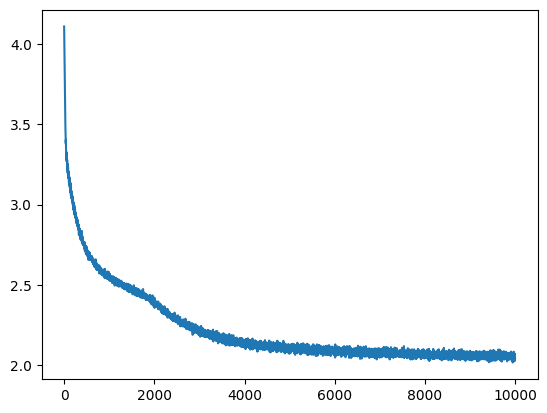

In [21]:
plt.plot(loss_list)
plt.show()

#### Example

In [23]:
tokens = text_generate(model,torch.zeros((1,),dtype=torch.long, device=device), 300, context_length=32)
print("".join(decode(tokens[0]))) 


Sthang: my that this moureich to fathey hel thou shast have you the the them himfsle:--
Therrt, cyived wome have intt
dronded, outue!
Hou, Annd of roubdy the,
Met, alow
Dave withes,
Tou thoustles all if bech how he seecke.

RAMENCANESSTEN:
The me womined
BRKENGY:
A by lake haves, his;
No theronet so


In [ ]:
x = torch.arange(12).view(3,4)
x

tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [ ]:
y = x.repeat_interleave(x.size(-2),dim=-2)
print(y.shape)
print(y)

torch.Size([9, 4])
tensor([[ 0,  1,  2,  3],
        [ 0,  1,  2,  3],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 4,  5,  6,  7],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [ 8,  9, 10, 11],
        [ 8,  9, 10, 11]])


In [ ]:
z = x.unsqueeze(dim=-3).repeat_interleave(x.size(-2),dim=-3)
print(z.shape)
z = z.view(x.size(-2)*x.size(-2), x.size(-1))
z

torch.Size([3, 3, 4])


tensor([[ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11],
        [ 0,  1,  2,  3],
        [ 4,  5,  6,  7],
        [ 8,  9, 10, 11]])

In [ ]:
w = torch.cat([z,y],dim=-1)
print(w)
w.sum(dim=-1).view(3,3)

tensor([[ 0,  1,  2,  3,  0,  1,  2,  3],
        [ 4,  5,  6,  7,  0,  1,  2,  3],
        [ 8,  9, 10, 11,  0,  1,  2,  3],
        [ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 4,  5,  6,  7,  4,  5,  6,  7],
        [ 8,  9, 10, 11,  4,  5,  6,  7],
        [ 0,  1,  2,  3,  8,  9, 10, 11],
        [ 4,  5,  6,  7,  8,  9, 10, 11],
        [ 8,  9, 10, 11,  8,  9, 10, 11]])


tensor([[12, 28, 44],
        [28, 44, 60],
        [44, 60, 76]])

In [ ]:
q = torch.arange(4).view(2,2)
q

tensor([[0, 1],
        [2, 3]])

In [ ]:
temp_q = q.repeat_interleave(q.size(-2),-2)
temp_q

tensor([[0, 1],
        [0, 1],
        [2, 3],
        [2, 3]])

In [ ]:
k = torch.arange(4).view(2,2)
k

tensor([[0, 1],
        [2, 3]])

In [ ]:
temp_k = (
    k.unsqueeze(dim=-3)
    .repeat_interleave(k.size(-2), dim=-3)
    .view(*k.shape[:-3], k.size(-2) * k.size(-2), k.size(-1))
)
temp_k

tensor([[0, 1],
        [2, 3],
        [0, 1],
        [2, 3]])

In [ ]:
torch.cat([temp_q, temp_k], dim=-1)

tensor([[0, 1, 0, 1],
        [0, 1, 2, 3],
        [2, 3, 0, 1],
        [2, 3, 2, 3]])